In [245]:
# Generate Multiline Vector from Labelbox Labels

from glob import glob
import pandas as pd
import json
import rasterio as rio
from shapely.geometry import LineString
from shapely.geometry import Polygon
from geopandas import GeoDataFrame
import geopandas
from shapely.ops import transform
from functools import partial
import pyproj
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Extract Chips

import gdal
import os

In [2]:
def add_trailing_slash(path):
    if path[-1] != '/':
        path += '/'
    return path

# Sum Length of Vectors

In [3]:
file = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/GEE/vectors/all_vectors/ISL/1/1_ISL.shp"

gdf = geopandas.read_file(file)

In [4]:
sample_line = gdf.loc[0]['geometry']

In [5]:
def line_length(shapefile):
    
    # Geometry transform function based on pyproj.transform
    project = partial(
        pyproj.transform,
        pyproj.Proj('EPSG:4326'),
        pyproj.Proj('EPSG:32633'))
    
    gdf = geopandas.read_file(file)
    
    line_sum = 0
    
    for geo in gdf["geometry"]:

        line2 = transform(project, geo)
        
        meter_length = line2.length
        
        line_sum += meter_length
        
    return line_sum

In [6]:
line_length(file)

63115.801088527696

In [13]:
def line_label_sums(vector_path,line_labels):
    
    vector_path = add_trailing_slash(vector_path)
    
    line_label_sums = {}
    
    for label in line_labels:
    
        vector_list = glob(f'{vector_path}/{label}/*/*.shp')
        
        geo_lengths = [line_length(i) for i in vector_list]
            
        line_label_sums[label] = sum(geo_lengths)
        
    return line_label_sums
    
    
    
vector_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/GEE/vectors/all_vectors"
line_labels = ["ISL","Roads","River"]

In [14]:
sum_dict = line_label_sums(vector_path,line_labels)

label_not_there
label_not_there
label_not_there


In [15]:
sum_dict

{'ISL': 3850063.8664001925,
 'Roads': 2145937.2370099425,
 'River': 1704126.6293902483}

In [116]:
pd.options.display.float_format = '{:,}'.format

In [117]:
sum_dict2 = sum_dict.copy()

In [118]:
for key in sum_dict2.keys():
    sum_dict2[key] = sum_dict2[key] / 1000

In [119]:
sum_dict2

{'ISL': 3850.0638664001926,
 'Roads': 2145.9372370099427,
 'River': 1704.1266293902484}

In [120]:
df = pd.DataFrame(sum_dict2,index=[0])

In [124]:
df.round()

,ISL,Roads,River
0,"3,850.0","2,146.0","1,704.0"


In [122]:
df2 = df.astype(int)

In [123]:
df2

,ISL,Roads,River
0,3850,2145,1704


In [101]:
df2 = df2.astype(str)

In [102]:
for column in df2:
    df2[column] = df2[column] + " " + "km"

In [112]:
df2

,ISL,Roads,River
0,3850 km,2145 km,1704 km


# Chips Per Size / Class

In [155]:
def chips_size_class(input_dir):
    
    chips = {}
    
    input_dir = add_trailing_slash(input_dir)
    
    chip_path_label = glob(f'{input_dir}/*/')
    
    for label_path in chip_path_label:
        
        label = label_path.split("/")[-2]
        
        chips[label] = {} 

        chip_path_size = glob(f'{label_path}/*/')
        
        for size_path in chip_path_size:
            
            size = size_path.split("/")[-2]
                
            chip_path_label_size = glob(f'{size_path}/*/*.tif')
                                        
            tif_len = len(chip_path_label_size)
                                        
            chips[label][size] = tif_len
                                        
            
                
    return chips
            

        
    
    
#     sizes = [100,200,1000]
#     labels = []

In [157]:
input_dir = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Chips/misha_polygons_v8/yes"

chips_count = chips_size_class(input_dir)

In [163]:
chips_df = pd.DataFrame(chips_count)

In [167]:
chips_df

,ISL,Habitation,Shifting_cultivation,Mining,Rainforest,Savannah,Water,River,Roads,Industrial_agriculture
100,6791,775,3852,220,24489,4034,1825,2570,1445,1450
200,2802,418,1342,95,7234,1164,499,1027,716,448
1000,299,94,141,15,572,83,31,147,134,45


<AxesSubplot:>

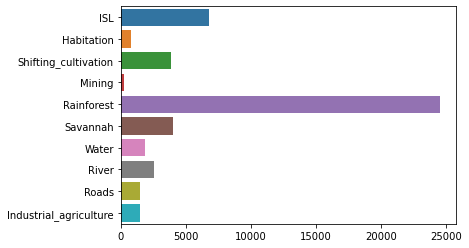

In [170]:
# ax = sns.barplot(x="tip", y="day", data=chips_df)

sns.barplot(data=chips_df.head(1), orient = 'h')

In [186]:
chips_df_2 = chips_df.reset_index()

In [189]:
chips_df_3 = chips_df_2.rename(columns={"index":"size"})

In [227]:
chips_df_3

,size,ISL,Habitation,Shifting_cultivation,Mining,Rainforest,Savannah,Water,River,Roads,Industrial_agriculture
0,100,6791,775,3852,220,24489,4034,1825,2570,1445,1450
1,200,2802,418,1342,95,7234,1164,499,1027,716,448
2,1000,299,94,141,15,572,83,31,147,134,45


In [228]:
# chips_df.melt('date', var_name='a', value_name='b')

chips_df_4 = pd.melt(chips_df_3, id_vars=["size"], value_vars=list(chips_df_3.columns[1:]))

In [229]:
chips_df_4["size"] = chips_df_4["size"].replace({"100": "1 x 1", "200": "2 x 2","1000": "10 x 10"})

In [230]:
chips_df_4.head(1)

,size,variable,value
0,1 x 1,ISL,6791


In [231]:
chips_df_5 = chips_df_4.rename(columns={"size": "Chip Size", "variable": "Label", "value":"Number of Chips"})

In [255]:
chips_df_5

,Chip Size,Label,Number of Chips
0,1 x 1,ISL,6791
1,2 x 2,ISL,2802
2,10 x 10,ISL,299
3,1 x 1,Habitation,775
4,2 x 2,Habitation,418
5,10 x 10,Habitation,94
6,1 x 1,Shifting_cultivation,3852
7,2 x 2,Shifting_cultivation,1342
8,10 x 10,Shifting_cultivation,141
9,1 x 1,Mining,220


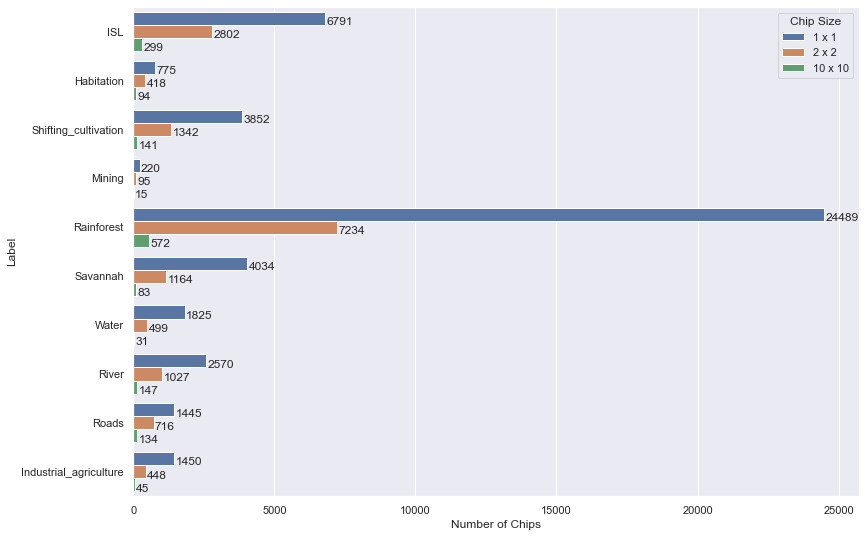

In [280]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(13,9)})
ax = sns.barplot(x='Number of Chips', y='Label', hue='Chip Size',data=chips_df_5)

for p in ax.patches:
    _x = p.get_x() + p.get_width() + float(50)
    _y = p.get_y() + p.get_height()
    value = int(p.get_width())
    ax.text(_x, _y, value, ha="left")
    
#     print(p)
#     ax.annotate(p.get_width(),(p.get_height(),p.get_width()))


# for index, row in chips_df_5.iterrows():
#     ax.text(row['Number of Chips'],row["Label"], row["Chip Size"], color='black', ha="center")


plt.show()

In [262]:
help(ax.annotate)

Help on method annotate in module matplotlib.axes._axes:

annotate(text, xy, *args, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Annotate the point *xy* with text *text*.
    
    In the simplest form, the text is placed at *xy*.
    
    Optionally, the text can be displayed in another position *xytext*.
    An arrow pointing from the text to the annotated point *xy* can then
    be added by defining *arrowprops*.
    
    Parameters
    ----------
    text : str
        The text of the annotation.  *s* is a deprecated synonym for this
        parameter.
    
    xy : (float, float)
        The point *(x, y)* to annotate. The coordinate system is determined
        by *xycoords*.
    
    xytext : (float, float), default: *xy*
        The position *(x, y)* to place the text at. The coordinate system
        is determined by *textcoords*.
    
    xycoords : str or `.Artist` or `.Transform` or callable or (float, float), default: 'data'
    
        The coordi

In [247]:
def show_values_on_bars(axs, h_v="h", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
    plt.show()
        
        
        
        
show_values_on_bars(ax,h_v="h",space=0.4)